# Requirements

In [ ]:
!pip install python-louvain
!pip install networkx
!pip install rdyn

# Algorithme

In [3]:
from collections import defaultdict
class Communities:
    
    def __init__(self,nodeMap,nextId):
        
        self.nCommunities = 0
        self.nNodes = 0
        self.nodeMap = bidict(nodeMap)
        self.nextId = nextId
        

In [4]:
# This class is taken from https://stackoverflow.com/questions/3318625/how-to-implement-an-efficient-bidirectional-hash-table
# and is used for the relation node-community. This allows us to get a list of nodes in a community 
# as well as getting the community of a node, without having to update two dictionnaries.

class bidict(dict):
    def __init__(self, *args, **kwargs):
        super(bidict, self).__init__(*args, **kwargs)
        self.inverse = {}
        for key, value in self.items():
            self.inverse.setdefault(value,[]).append(key) 

    def __setitem__(self, key, value):
        if self.inverse is None:
            self.inverse = {}
        if key in self:
            self.inverse[self[key]].remove(key) 
        super(bidict, self).__setitem__(key, value)
        self.inverse.setdefault(value,[]).append(key)        

    def __delitem__(self, key):
        self.inverse.setdefault(self[key],[]).remove(key)
        if self[key] in self.inverse and not self.inverse[self[key]]: 
            del self.inverse[self[key]]
        super(bidict, self).__delitem__(key)

In [90]:
import random
import math
import networkx as nx
import community as community_louvain

class Dynamo_Algorithm:
    
    def __init__(self,graph_old,communities_old):
        self.network_old = graph_old
        self.network_new = graph_old
        self.communities_old = communities_old
        self.communities_new = communities_old
    
    def addNewData(self,modifiedEdges,addedNodes,deletedNodes):
        
        # "new" snapshot is now past
        self.network_old = copy.deepcopy(self.network_new)
            
        self.network_new.add_nodes_from(addedNodes)
        self.network_new.add_edges_from(modifiedEdges)
        self.network_new.remove_nodes_from(deletedNodes)
            
        newCommunities = self.dynamoAlgorithm(modifiedEdges,addedNodes,deletedNodes)
        
        return newCommunities
        
    def dynamoAlgorithm(self,modifiedEdges,modifiedNodes,deletedNodes):
        # Applies the Dynamo algorithm.
        #
        # Input: graph_old, graph_new, communities_old
        # Returns: communities_new
        self.communities_new = copy.deepcopy(self.communities_old)
        c1, c2 = self.dynamoInit(modifiedEdges,modifiedNodes,deletedNodes)
            
        
        
        for single_community in c1:
            # get all nodes in community
            nodes = self.communities_new.nodeMap.inverse[single_community]
            for node in list(nodes):
                # initialize singleton communities
                self.communities_new.nodeMap[node] = self.communities_new.nextId
                self.communities_new.nextId += 1
        for duo_nodes in c2:
            # initialize two-vertices community for tuples
            for node in duo_nodes:
                self.communities_new.nodeMap[node] = self.communities_new.nextId
            self.communities_new.nextId += 1
        
        for node in modifiedNodes:
            if node not in self.communities_new.nodeMap:
                print("a")
                # New node has no edges, add its own community
                self.communities_new.nodeMap[node] = self.communities_new.nextId
                # Add null edge
                self.network_new.add_edge(node,node,weight=0)
                self.communities_new.nextId += 1
                
                
                
            
        
        bigGraph = self.makeCommunityGraph()
        
        # Run the louvain algorithm
        partition = community_louvain.best_partition(bigGraph)
        
        for node in self.network_new.nodes():
            prev_comm = self.communities_new.nodeMap[node]
            self.communities_new.nodeMap[node] = partition[prev_comm]
        self.communities_new.nodeMap = bidict(self.communities_new.nodeMap)
        
        self.communities_old = copy.deepcopy(self.communities_new)
        #update nextId
        self.communities_new.nextId = max(partition.items(), key=operator.itemgetter(1))[1] + 1
        
        return self.communities_new.nodeMap
        
    def dynamoInit(self,modifiedEdges,addedNodes,deletedNodes):
        c1 = set()
        c2 = set()
        for addEdge in modifiedEdges:
            node_1 = addEdge[0]
            node_2 = addEdge[1]
            for k in addEdge:
                
                # Case 4: Node(Vertex) Deletion
                if k in deletedNodes:
                    c1.add(self.communities_old.nodeMap[k])
                    for edge in self.network_old.edges(k):
                        c1.add(self.communities_old.nodeMap[edge])
                    
                # Case 3: Node(Vertex) Addition
                if k in addedNodes:
                    wmax = 0
                    comm_2 = None
                    # Add node to nodeMap
                    if k not in self.communities_new.nodeMap.keys():
                        #print(self.communities_new.nodeMap.keys())
                        self.communities_new.nodeMap[k] = self.communities_new.nextId
                        #print(self.communities_new.nextId)
                        #print(k)
                        c1.add(self.communities_new.nextId)
                        self.communities_new.nextId+=1
                    for edge in self.network_new.edges(k):
                        # WE NEED TO MAKE SURE THAT EACH ADDED NODE HAS AT LEAST ONE EDGE
                        weight = self.network_new.get_edge_data(edge[0],edge[1])["weight"]
                        if weight > wmax:
                            wmax = weight
                            comm_2 = (k,edge[1])
                            # TODO: if edge[1] is another newly added vertice
                            if edge[1] not in addedNodes:
                                c1.add(self.communities_old.nodeMap[edge[1]])
                    # The link with the most weight is initialized as a two-vertices community
                    c2.add(comm_2)
                    # check w value for each community this 
                    # vertice is linked to
                    
            if node_1 not in addedNodes and node_2 not in addedNodes:
                if self.network_old.has_edge(node_1,node_2) and ((not self.network_new.has_edge(node_1,node_2)) or (self.network_old.get_edge_data(node_1,node_2)["weight"] > self.network_new.get_edge_data(node_1,node_2)["weight"])):
                    if self.communities_old.nodeMap[node_1] == self.communities_old.nodeMap[node_2]:
                        # Intra community weight increase. Initialize this community and all communities adjacent to 
                        # node_1 and node_2 as singleton communities
                        c1.add(self.communities_old.nodeMap[node_1])
                        for k in addEdge:
                            for edge in self.network_old.edges(k):
                                c1.add(self.communities_old.nodeMap[edge[1]])
                                
                        
                elif (not self.network_old.has_edge(node_1,node_2)) or (self.network_old.get_edge_data(node_1,node_2)["weight"] < self.network_new.get_edge_data(node_1,node_2)["weight"]):
                    if self.communities_old.nodeMap[node_1] == self.communities_old.nodeMap[node_2]:
                        # Intra community weight increase. 2 cases are possible: keeping the community structure unchanged,
                        # or dividing the community into smaller communities. To acount for theses cases, initialize the two nodes 
                        # as a two-vertice community and the other nodes in the community as singleton communities.
                        comm_2 = (node_1,node_2)
                        # two-vertices community 
                        c2.add(comm_2)
                        # community of node_1 and node_2 marked as singleton communities
                        c1.add(self.communities_old.nodeMap[node_1])
                    else:
                        # Cross community weight increase. If the weight increase is greater than the threshold, 
                        # make the same approach as the intra-community weight increase, else keep the structure unchanged.
                        if (not self.network_old.has_edge(node_1,node_2)):
                            delta_w = self.network_new.get_edge_data(node_1,node_2)["weight"]
                        else:
                            delta_w = self.network_new.get_edge_data(node_1,node_2)["weight"] - self.network_old.get_edge_data(node_1,node_2)["weight"]
                        if self.compute_threshold(node_1,node_2, delta_w):
                            comm_2 = (node_1,node_2)
                            # two-vertices community 
                            c2.add(comm_2)
                            # community of node_1 and node_2 marked as singleton communities
                            c1.add(self.communities_old.nodeMap[node_1])
                            c1.add(self.communities_old.nodeMap[node_2])
        return c1, c2
                        
                
    
    
    def compute_threshold(self,node_i,node_j,delta_w):
        """
        
        Computes the threshold to decide whether to merge communities 
        or divide them with a edge increase between two nodes of 
        different communities.
        
        Parameters:
        
        - node_i and node_j: the two nodes with edge increase
        - delta_w: the delta of the weight with the last epoch
    
        """
        comm_i_nodes = self.communities_new.nodeMap.inverse[self.communities_new.nodeMap[node_i]]
        comm_j_nodes = self.communities_new.nodeMap.inverse[self.communities_new.nodeMap[node_j]]
        
        comm_i_j_edges = nx.edge_boundary(self.network_new,comm_i_nodes,comm_j_nodes,data='weight')
        # total weight of intra edges in both communities
        alpha2 = sum([x[2] for x in comm_i_j_edges]) # - community_k edges intra
        
        node_i_degree = self.network_new.degree(node_i,'weight')
        node_j_degree = self.network_new.degree(node_j,'weight')
        # beta2 is the sum of the degrees of the nodes
        beta2 = node_i_degree + node_j_degree
        
        m = self.network_new.number_of_edges()
        
        d1 = 2*m - alpha2 - beta2
        d2 = (m * alpha2) + (node_i_degree * node_j_degree)
        return 2 * delta_w + d1 > math.sqrt(pow(d1,2) + (4 * d2))
        
        
    def makeCommunityGraph(self):
        # To make updating the model easier, we treat each communities as a singular node. This method constructs a graph 
        # with all the communities as nodes so that we can apply the louvain algorithm and save time.
        bigGraph = nx.Graph()
        
        for node1, node2, weight in self.network_new.edges(data='weight'):
            comm_node1 = self.communities_new.nodeMap[node1]
            comm_node2 = self.communities_new.nodeMap[node2]
            prev_weight = bigGraph.get_edge_data(comm_node1, comm_node2, {weight: 0}).get(weight, 1)
            bigGraph.add_edge(comm_node1,comm_node2,weight=weight + prev_weight)
            
        return bigGraph
        
    def getNeighborCommunity(self,communityId):
        # If there are singleton communities after the algorithm, find the adjacent community for suggestions
        wmax = 0
        boundary_edges = nx.edge_boundary(self.network_new,self.communities_new.nodeMap.inverse[communityId],data='weight')
        comm_2 = None
        for edge in boundary_edges:
            if edge[2] > wmax:
                wmax = edge[2]
                comm_2 = self.communities_new.nodeMap[edge[1]]
                
        if comm_2 is None:
            # return a random community
            while True:
                rnd_comm = random.randint(0, self.communities_new.nextId )
                if rnd_comm != communityId:
                    break
            return rnd_comm
        return comm_2
        
        
        

# Experiments:

## NMI/ARI Experiment:

In [ ]:
# Extract clusterings from ground truth (Rdyn) into files for xmeasures
import os.path
from os import path
import operator
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
import copy


def format_GT_clusters(folderName, iterations):
    counter = 0
    edges_old = []
    edges_new = []
    nmi = []
    ari = []
    dyn = None
    seen_nodes = set()
    for i in range(iterations):
        true_labels = []
        predicted_labels = []
        
        communitiesFileName = "communities-"+str(i)+".txt"
        communitiesFilePath = "results/" + str(folderName) + "/" + str(communitiesFileName)
        #print(communitiesFilePath)
        #print(path.exists(communitiesFilePath))
        if path.exists(communitiesFilePath):
            
            labels_tuples = []
            for line in open(communitiesFilePath,"r"):
                label, line = line.split("\t")
                line = line.replace("[","")
                line = line.replace("]","")
                for node in line.split(","):
                    labels_tuples.append((label,node))
            # Format true_labels
            sorted_labels = sorted(labels_tuples, key=operator.itemgetter(1))
            for label in sorted_labels:
                true_labels.append(label[0])
            
            
            if len(edges_old) == 0:
                # Construct graph for Dynamo, first pass through Louvain
                graphFileName = "graph-" + str(i) + ".txt"
                graphFilePath = "results/" + str(folderName) + "/" + str(graphFileName)
                
                for line in open(graphFilePath,"r"):
                    node1, node2 = line.split("\t")
                    edges_old.append((int(node1), int(node2)))
                G = nx.Graph()
                G.add_edges_from(edges_old, weight=1)
                partition = community_louvain.best_partition(G)
                communities = Communities(partition,max(partition.items(), key=operator.itemgetter(1))[1] + 1)
                dyn = Dynamo_Algorithm(G,communities)
                
            else:
                new_nodes = []
                modified_edges = []
                
                graphFileName = "graph-" + str(i) + ".txt"
                graphFilePath = "results/" + str(folderName) + "/" + str(graphFileName)
                
                for line in open(graphFilePath,"r"):
                    node1, node2 = line.split("\t")
                    seen_nodes.add(int(node1))
                    seen_nodes.add(int(node2))
                    edges_new.append((int(node1), int(node2)))
                    
                # compare edges_new and edges_old to find added/deleted edges
                
                for edge in edges_old:
                    if edge not in edges_new:
                        # deleted edge
                        modified_edges.append((int(edge[0]),int(edge[1]),{'weight':0}))
                for edge in edges_new:
                    if edge not in edges_old:
                        modified_edges.append((int(edge[0]),int(edge[1]),{'weight':1}))
                    if edge[0] not in seen_nodes:
                        new_nodes.add(int(edge[0]))
                        seen_nodes.add(int(edge[0]))
                    if edge[1] not in seen_nodes:
                        new_nodes.add(int(edge[1]))
                        seen_nodes.add(int(edge[1]))
                
                edges_old = edges_new
                dyn.addNewData(modified_edges,new_nodes,[])
                communities = dyn.communities_new.nodeMap
            # Extract communities into file
            
            for node in sorted(set(dyn.communities_old.nodeMap.keys())):
                predicted_labels.append(dyn.communities_old.nodeMap[node])
            counter +=1
            
            # Compute NMI and ARI
            #print(len(true_labels))
            #print(len(predicted_labels))
            nmi.append(normalized_mutual_info_score(true_labels,predicted_labels))
            ari.append(adjusted_rand_score(true_labels,predicted_labels))
    return nmi, ari

In [ ]:
# Using Rdyn
import math
import os
from rdyn import RDyn

number_of_nodes = [200, 400, 600, 800, 1000]
            
nmi_nodes = []
ari_nodes = []


    
for nn in number_of_nodes:
    iterations = 125
    rdb = RDyn(size=nn,iterations=iterations,max_evts=1,sigma=0.7,avg_deg=15,quality_threshold=0.3,prenewal=0.8)
    rdb.execute()
            
    # value to iterations
    folderName = str(nn) + "_125_15_0.7_0.8_0.3_1"
    nmi, ari = format_GT_clusters(folderName,iterations)
    nmi_nodes.append(nmi)
    ari_nodes.append(ari)


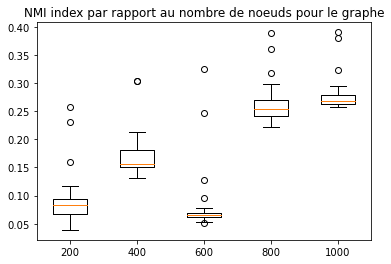

In [107]:
fig, ax = plt.subplots()

ax.boxplot(nmi_nodes, labels=[200,400,600,800,1000])
plt.title("NMI index par rapport au nombre de noeuds pour le graphe")
plt.show()

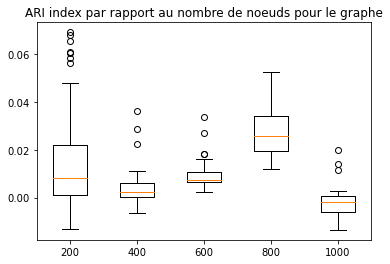

In [108]:
fig, ax = plt.subplots()

ax.boxplot(ari_nodes, labels=[200,400,600,800,1000])
plt.title("ARI index par rapport au nombre de noeuds pour le graphe")
plt.show()

## Modularity and Time Experiment:

In [89]:
# pandas sort by time
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta

def prepareGraph(datesFile,citationsFile):
    df = pd.read_csv('hep-th-slacdates',delimiter=' ',names=['Id','Date'])
    df['Date'] =pd.to_datetime(df.Date)
    df = df.sort_values('Date')

    initial_date = '1992-04-01'
    date_threshold = datetime.datetime.strptime(initial_date, '%Y-%m-%d')

    dates_epoch = {}
    currentIndex = 0
    for index, elements in df.iterrows():
        if elements[1] < date_threshold:
            dates_epoch[elements[0]] = currentIndex
        else:
            currentIndex += 1
            dates_epoch[elements[0]] = currentIndex
            date_threshold += relativedelta(months=+4)

    dates_epoch = bidict(dates_epoch)

    graphs={}
    seen_nodes = {}
    for line in open("hep-th-citations"):
        node1, node2 = line.split()
        node1_index = dates_epoch[int(node1)]
        node2_index = dates_epoch[int(node2)]
        if not max(node1_index, node2_index) in graphs:
            graphs[max(node1_index, node2_index)] = [(node1,node2,{'weight' : 1})]
            seen_nodes[max(node1_index, node2_index)] = set()
            if node1_index <= max(node1_index, node2_index):
                seen_nodes[max(node1_index, node2_index)].add(node1)
            if node2_index <= max(node1_index, node2_index):
                seen_nodes[max(node1_index, node2_index)].add(node2)
        else:
            graphs[max(node1_index, node2_index)].append((node1,node2,{'weight' : 1}))
            if node1_index <= max(node1_index, node2_index):
                seen_nodes[max(node1_index, node2_index)].add(node1)
            if node2_index <= max(node1_index, node2_index):
                seen_nodes[max(node1_index, node2_index)].add(node2)
    return graphs

graph_th = prepareGraph('hep-th-slacdates',"hep-th-citations")
graph_ph = prepareGraph('hep-th-slacdates',"hep-ph-citations")

In [94]:
# Hand-Made Dynamo:
import operator
import networkx.algorithms.community as nx_comm
import copy
import time


def convert_listset(communities):
    comm_set = []
    for comm_idx in set(communities.values()):
        comm_set.append(set(communities.inverse[comm_idx]))
    return comm_set
    

def computeExperiment(graphs):
    modularity_Dynamo = []
    times_Dynamo = []

    G = nx.Graph()
    for index, element in enumerate(graphs):
        if index == 0:
            
            G.add_edges_from(graphs[index], weight=1)
            # run louvain
            stime = time.time()
            partition = community_louvain.best_partition(G)
            communities = Communities(partition,max(partition.items(), key=operator.itemgetter(1))[1] + 1)
            dyn = Dynamo_Algorithm(G,communities)
            communities = convert_listset(dyn.communities_old.nodeMap)
        else:
            stime = time.time()
            communities = convert_listset(dyn.addNewData(graphs[index],list(seen_nodes[index]),[]))
        times_Dynamo.append(time.time() - stime)
        modularity_Dynamo.append(nx_comm.modularity(G,communities))

    modularity_Louvain = []
    times_Louvain = []

    for index, element in enumerate(graphs):
        if index == 0:
            G = nx.Graph()

            G.add_edges_from(graphs[index], weight=1)
            # run louvain
            stime = time.time()
            partition = community_louvain.best_partition(G)
            communities = bidict(partition)
            communities = convert_listset(communities)

        else:
            G.add_edges_from(graphs[index], weight=1)
            # run louvain
            stime = time.time()
            partition = community_louvain.best_partition(G)
            communities = bidict(partition)
            communities = convert_listset(communities)
        times_Louvain.append(time.time() - stime)
        modularity_Louvain.append(nx_comm.modularity(G,communities))
        
    return modularity_Dynamo, modularity_Louvain, times_Dynamo, times_Louvain
    


In [95]:
modularity_Dynamo_P, modularity_Louvain_P, times_Dynamo_P, times_Louvain_P = computeExperiment(graph_ph)
modularity_Dynamo_T, modularity_Louvain_T, times_Dynamo_T, times_Louvain_T = computeExperiment(graph_ph)

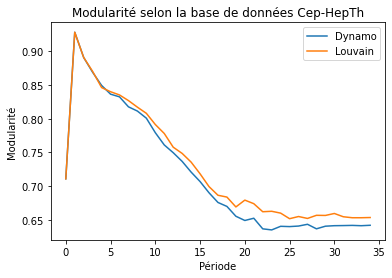

In [87]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(modularity_Dynamo_T,  label="Dynamo")
ax.plot(modularity_Louvain_T,  label="Louvain")
ax.legend()
plt.xlabel('Période')
plt.ylabel('Modularité')
plt.title('Modularité selon la base de données Cep-HepTh')
plt.show()

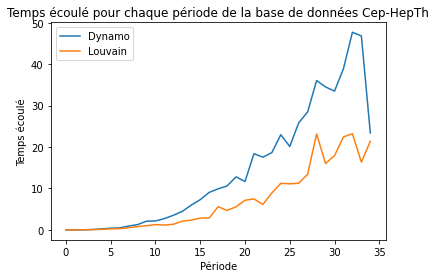

In [110]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(times_Dynamo_T,  label="Dynamo")
ax.plot(times_Louvain_T,  label="Louvain")
ax.legend()
plt.xlabel('Période')
plt.ylabel('Temps écoulé')
plt.title('Temps écoulé pour chaque période de la base de données Cep-HepTh')
plt.show()

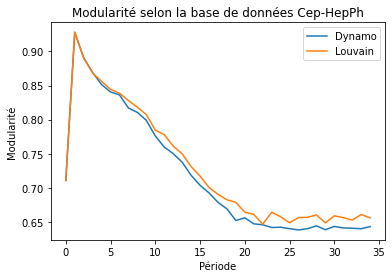

In [96]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(modularity_Dynamo_P,  label="Dynamo")
ax.plot(modularity_Louvain_P,  label="Louvain")
ax.legend()
plt.xlabel('Période')
plt.ylabel('Modularité')
plt.title('Modularité selon la base de données Cep-HepPh')
plt.show()

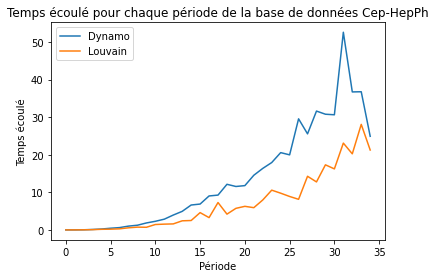

In [109]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(times_Dynamo_P,  label="Dynamo")
ax.plot(times_Louvain_P,  label="Louvain")
ax.legend()
plt.xlabel('Période')
plt.ylabel('Temps écoulé')
plt.title('Temps écoulé pour chaque période de la base de données Cep-HepPh')
plt.show()